# Árboles de Decisión

- Néstor I. Martínez Ostoa
- Minería de Datos
- Lic. en Ciencia de Datos
- IIMAS - UNAM

---

**Dataset**: https://www.kaggle.com/hellbuoy/car-price-prediction


**Descripción**: 

El objetivo de este notebook será mejorar la predicción actual de la variable precio (```price```) dentro del *dataset* de carros mundiales. El rendimiento del modelo está dado mediante un árbol de decisión y considera las siguientes variables (actualmente): 

- ```enginesize```
- ```horsepower```
- ```cardwidth```
- ```curbweight```

Las variables con las que trabajaremos para el nuevo modelo son las siguientes: 

- ```horsepower```
- ```cylindernumber```
- ```enginelocation```
- ```boreratio```
- ```carheight```
- ```drivewheel```
-```enginesize```
-```citympg```
-```fuelsystem```
-```peakrpm```
-```carlength```
- ```carbody```
-```curbweight```
-```stroke```

Las variables con las que reemplazaremos las variables del modelo actual obtuvieron los siguientes resultados estadísticos con base en una regresión lineal múltiple: 
- R-cuadrada: $0.987$
- R-cuadrada ajustada: $0.966$

--- 

**Árboles de decisión:**

Los árboles de decisión son comunmente usados para representar visualmente relaciones entre variables. Para nuestro problema, usaremos un árbol de regresión pues quereos predecir el valor de la variable ```price``` la cual es numérica. La representación visual de este árbol nos dirá las variables a utilizar para predecir el precio de los coches y bajo qué condiciones usarlas. 

In [39]:
library(dplyr)
library(rpart)
library(rpart.plot)
library(caret)
library(mltools)
library(data.table)

## Exploración de Datos

In [2]:
data = read.csv('data.csv')

# Quitamos car_ID y CarName para evitar sesgos con base 
# en las marcas de los coches
data = data %>% select(-car_ID, -CarName)


head(data)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,⋯,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,⋯,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
2,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,⋯,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
3,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,⋯,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
4,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,⋯,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
5,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,⋯,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
6,2,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,⋯,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [3]:
categorical_data <- select_if(data, is.character)
str(categorical_data)

'data.frame':	205 obs. of  9 variables:
 $ fueltype      : chr  "gas" "gas" "gas" "gas" ...
 $ aspiration    : chr  "std" "std" "std" "std" ...
 $ doornumber    : chr  "two" "two" "two" "four" ...
 $ carbody       : chr  "convertible" "convertible" "hatchback" "sedan" ...
 $ drivewheel    : chr  "rwd" "rwd" "rwd" "fwd" ...
 $ enginelocation: chr  "front" "front" "front" "front" ...
 $ enginetype    : chr  "dohc" "dohc" "ohcv" "ohc" ...
 $ cylindernumber: chr  "four" "four" "six" "four" ...
 $ fuelsystem    : chr  "mpfi" "mpfi" "mpfi" "mpfi" ...


Obtenemos valores estadísticos para las columnas numéricas de los datos:

In [4]:
numeric_data <- select_if(data, is.numeric)
summary(numeric_data)

   symboling         wheelbase        carlength        carwidth    
 Min.   :-2.0000   Min.   : 86.60   Min.   :141.1   Min.   :60.30  
 1st Qu.: 0.0000   1st Qu.: 94.50   1st Qu.:166.3   1st Qu.:64.10  
 Median : 1.0000   Median : 97.00   Median :173.2   Median :65.50  
 Mean   : 0.8341   Mean   : 98.76   Mean   :174.0   Mean   :65.91  
 3rd Qu.: 2.0000   3rd Qu.:102.40   3rd Qu.:183.1   3rd Qu.:66.90  
 Max.   : 3.0000   Max.   :120.90   Max.   :208.1   Max.   :72.30  
   carheight       curbweight     enginesize      boreratio        stroke     
 Min.   :47.80   Min.   :1488   Min.   : 61.0   Min.   :2.54   Min.   :2.070  
 1st Qu.:52.00   1st Qu.:2145   1st Qu.: 97.0   1st Qu.:3.15   1st Qu.:3.110  
 Median :54.10   Median :2414   Median :120.0   Median :3.31   Median :3.290  
 Mean   :53.72   Mean   :2556   Mean   :126.9   Mean   :3.33   Mean   :3.255  
 3rd Qu.:55.50   3rd Qu.:2935   3rd Qu.:141.0   3rd Qu.:3.58   3rd Qu.:3.410  
 Max.   :59.80   Max.   :4066   Max.   :326.0   Ma

In [5]:
str(numeric_data)

'data.frame':	205 obs. of  15 variables:
 $ symboling       : int  3 3 1 2 2 2 1 1 1 0 ...
 $ wheelbase       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ carlength       : num  169 169 171 177 177 ...
 $ carwidth        : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 67.9 ...
 $ carheight       : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 52 ...
 $ curbweight      : int  2548 2548 2823 2337 2824 2507 2844 2954 3086 3053 ...
 $ enginesize      : int  130 130 152 109 136 136 136 136 131 131 ...
 $ boreratio       : num  3.47 3.47 2.68 3.19 3.19 3.19 3.19 3.19 3.13 3.13 ...
 $ stroke          : num  2.68 2.68 3.47 3.4 3.4 3.4 3.4 3.4 3.4 3.4 ...
 $ compressionratio: num  9 9 9 10 8 8.5 8.5 8.5 8.3 7 ...
 $ horsepower      : int  111 111 154 102 115 110 110 110 140 160 ...
 $ peakrpm         : int  5000 5000 5000 5500 5500 5500 5500 5500 5500 5500 ...
 $ citympg         : int  21 21 19 24 18 19 19 19 17 16 ...
 $ highwaympg      : int  27 27 26 30 22 25 25 25 20 22 ...
 $ price      

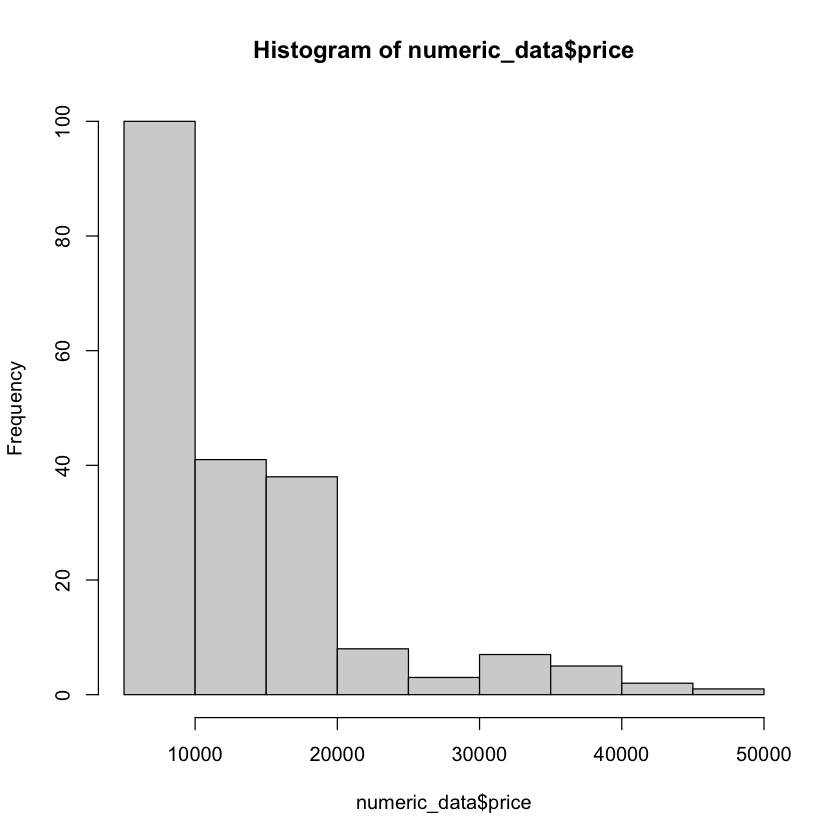

In [6]:
hist(numeric_data$price)

## Modelo viejo

Variables: 
- ```enginesize```
- ```horsepower```
- ```cardwidth```
- ```curbweight```

In [7]:
old_model_data = data %>% select(enginesize, horsepower, carwidth, curbweight, price)
head(old_model_data)

,enginesize,horsepower,carwidth,curbweight,price
,<int>,<int>,<dbl>,<int>,<dbl>
1,130,111,64.1,2548,13495
2,130,111,64.1,2548,16500
3,152,154,65.5,2823,16500
4,109,102,66.2,2337,13950
5,136,115,66.4,2824,17450
6,136,110,66.3,2507,15250


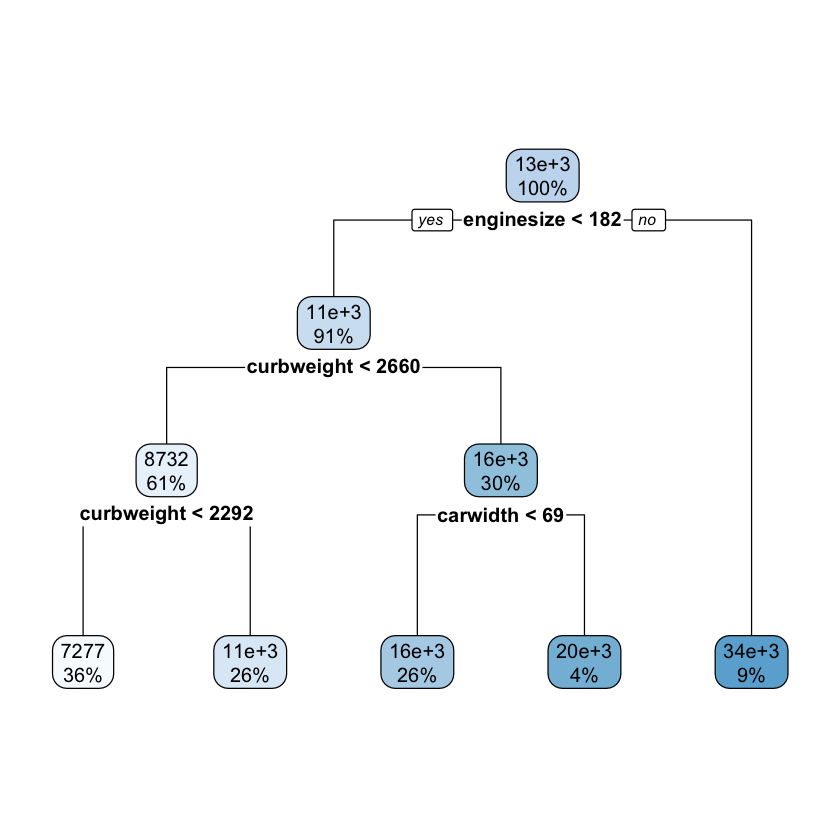

In [8]:
old_model_tree = rpart(
    price~.,
    data=old_model_data
)
rpart.plot(old_model_tree)

## New Model

Variables: 

- ```horsepower```
- ```cylindernumber```
- ```enginelocation```
- ```boreratio```
- ```carheight```
- ```drivewheel```
-```enginesize```
-```citympg```
-```fuelsystem```
-```peakrpm```
-```carlength```
- ```carbody```
-```curbweight```
-```stroke```


In [9]:
new_model_data = data %>% select(horsepower, 
                                 cylindernumber, boreratio, carheight, drivewheel, enginesize, citympg,
                                 fuelsystem, peakrpm, carlength, carbody, curbweight, stroke, price)
head(new_model_data)

,horsepower,cylindernumber,boreratio,carheight,drivewheel,enginesize,citympg,fuelsystem,peakrpm,carlength,carbody,curbweight,stroke,price
,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
1,111,four,3.47,48.8,rwd,130,21,mpfi,5000,168.8,convertible,2548,2.68,13495
2,111,four,3.47,48.8,rwd,130,21,mpfi,5000,168.8,convertible,2548,2.68,16500
3,154,six,2.68,52.4,rwd,152,19,mpfi,5000,171.2,hatchback,2823,3.47,16500
4,102,four,3.19,54.3,fwd,109,24,mpfi,5500,176.6,sedan,2337,3.40,13950
5,115,five,3.19,54.3,4wd,136,18,mpfi,5500,176.6,sedan,2824,3.40,17450
6,110,five,3.19,53.1,fwd,136,19,mpfi,5500,177.3,sedan,2507,3.40,15250


Empezamos transformando de variables categóricas a variables numéricas para:
- ```cylindernumber```
- ```fuelsystem```
- ```carbody```

In [25]:
cylinder_number_encode <- function(data) {
    d <- c()
    for (x in data$cylindernumber) {
        if (x == "four") {
            d <- c(d, 4)
        } else if (x == "five") {
            d <- c(d, 5)                
        } else if (x == "six") {
            d <- c(d, 6)
        } else if (x == "three") {
            d <- c(d, 3)
        } else if (x == "twelve") {
            d <- c(d, 12)
        } else if (x == "two") {
            d <- c(d, 2)
        } else if (x == "eight") {
            d <- c(d, 8)
        }
    }
    return (d)
}

fuel_system_encode <- function(data) {
    d <- c()
    for (x in data$fuelsystem) {
        if (x == "mpfi") {
            d <- c(d, 0)
        } else if (x == "2bbl") {
            d <- c(d, 1)                
        } else if (x == "mfi") {
            d <- c(d, 2)
        } else if (x == "1bbl") {
            d <- c(d, 3)
        } else if (x == "spfi") {
            d <- c(d, 4)
        } else if (x == "4bbl") {
            d <- c(d, 5)
        } else if (x == "idi") {
            d <- c(d, 6)
        } else if (x == "spdi") {
            d <- c(d, 7)        
        }
    }
    return (d)
}

car_body_encode <- function(data) {
    d <- c()
    for (x in data$carbody) {
        if (x == "convertible") {
            d <- c(d, 0)
        } else if (x == "hatchback") {
            d <- c(d, 1)                
        } else if (x == "sedan") {
            d <- c(d, 2)
        } else if (x == "wagon") {
            d <- c(d, 3)
        } else if (x == "hardtop") {
            d <- c(d, 4)
        }
    }
    return(d)
}

drivewheel_encode <- function(data) {
    d <- c()
    for (x in data$drivewheel) {
        if (x == "rwd") {
            d <- c(d, 0)
        } else if (x == "fwd") {
            d <- c(d, 1)                
        } else if (x == "4wd") {
            d <- c(d, 2)
        }
    }
    return(d)
}


new_model_label_encode <- function(data) {
    data$cylindernumber <- cylinder_number_encode(data)
    data$cylindernumber <- cylinder_number_encode(data)
    data$fuelsystem <- fuel_system_encode(data)
    data$carbody <- car_body_encode(data)
    data$drivewheel <- drivewheel_encode(data)
    return (data)
}

In [27]:
new_model_data <- new_model_label_encode(new_model_data)
head(new_model_data)

,horsepower,boreratio,carheight,enginesize,citympg,peakrpm,carlength,curbweight,stroke,price
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,111,3.47,48.8,130,21,5000,168.8,2548,2.68,13495
2,111,3.47,48.8,130,21,5000,168.8,2548,2.68,16500
3,154,2.68,52.4,152,19,5000,171.2,2823,3.47,16500
4,102,3.19,54.3,109,24,5500,176.6,2337,3.40,13950
5,115,3.19,54.3,136,18,5500,176.6,2824,3.40,17450
6,110,3.19,53.1,136,19,5500,177.3,2507,3.40,15250


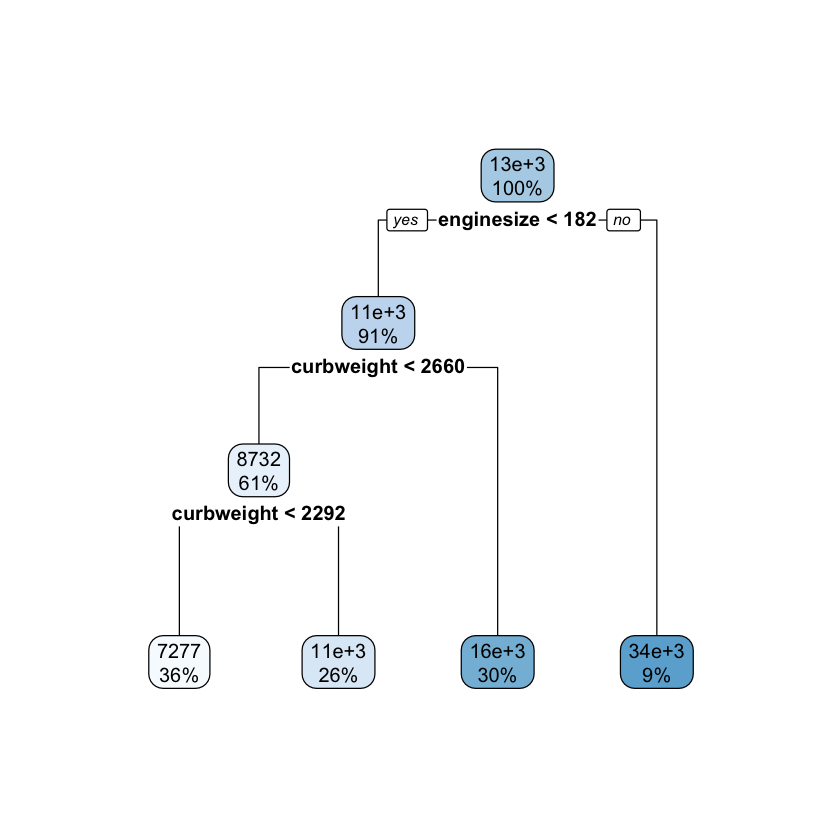

In [28]:
new_model_tree = rpart(
    price~.,
    data=new_model_data
)
rpart.plot(new_model_tree)

## Entrenamiento y Prueba - Old Model

In [37]:
set.seed(1)

# Train test split
temp <- sample(nrow(data), nrow(data)*.8)
training_data <- data[temp,]
test_data <- data[-temp,]


# X_train, y_train, X_test, y_test
X_train = training_data %>% select(enginesize, horsepower, carwidth, curbweight)
X_test = test_data %>% select(enginesize, horsepower, carwidth, curbweight)
y_train = training_data$price
y_test = test_data$price

# Training and test
y_predict = predict(rpart(y_train~., X_train), X_test)
m = length(y_predict)

# Cost
paste("El costo del modelo viejo es: ", sqrt((1/m)*sum((y_test-y_predict)^2)))

[1] "El costo del modelo viejo es:  2727.15724760852"

## Entrenamiento y Prueba - New Model

In [38]:
set.seed(1)


# Train test split
temp <- sample(nrow(data), nrow(data)*.8)
training_data <- data[temp,]
test_data <- data[-temp,]


# X_train, y_train, X_test, y_test
X_train = training_data %>% select(horsepower, 
                                 cylindernumber, boreratio, carheight, drivewheel, enginesize, citympg,
                                 fuelsystem, peakrpm, carlength, carbody, curbweight, stroke, price)
X_train = new_model_label_encode(X_train)

X_test = test_data %>% select(horsepower, 
                                 cylindernumber, boreratio, carheight, drivewheel, enginesize, citympg,
                                 fuelsystem, peakrpm, carlength, carbody, curbweight, stroke, price)
X_test = new_model_label_encode(X_test)

y_train = training_data$price
y_test = test_data$price

## Training and test
y_predict = predict(rpart(y_train~., X_train), X_test)
m = length(y_predict)

# Cost
paste("El costo del modelo nuevo es: ", sqrt((1/m)*sum((y_test-y_predict)^2)))

[1] "El costo del modelo nuevo es:  1219.16024028622"

## Conclusiones

Podemos observar claramente que con las variables del modelo nuevo, el costo del modelo baja sustancialmente de $2727$ a $1219$ por lo que podemos asegurar que para estos datos, utilizar las variables del nuevo modelo explican de mejor manera la varianza de los datos! 

**Variables modelo viejo:**
- ```enginesize```
- ```horsepower```
- ```cardwidth```
- ```curbweight```

**Variables modelo nuevo:**

- ```horsepower```
- ```cylindernumber```
- ```enginelocation```
- ```boreratio```
- ```carheight```
- ```drivewheel```
-```enginesize```
-```citympg```
-```fuelsystem```
-```peakrpm```
-```carlength```
- ```carbody```
-```curbweight```
-```stroke```

[1] "Árbol de decisión - Modelo Viejo"


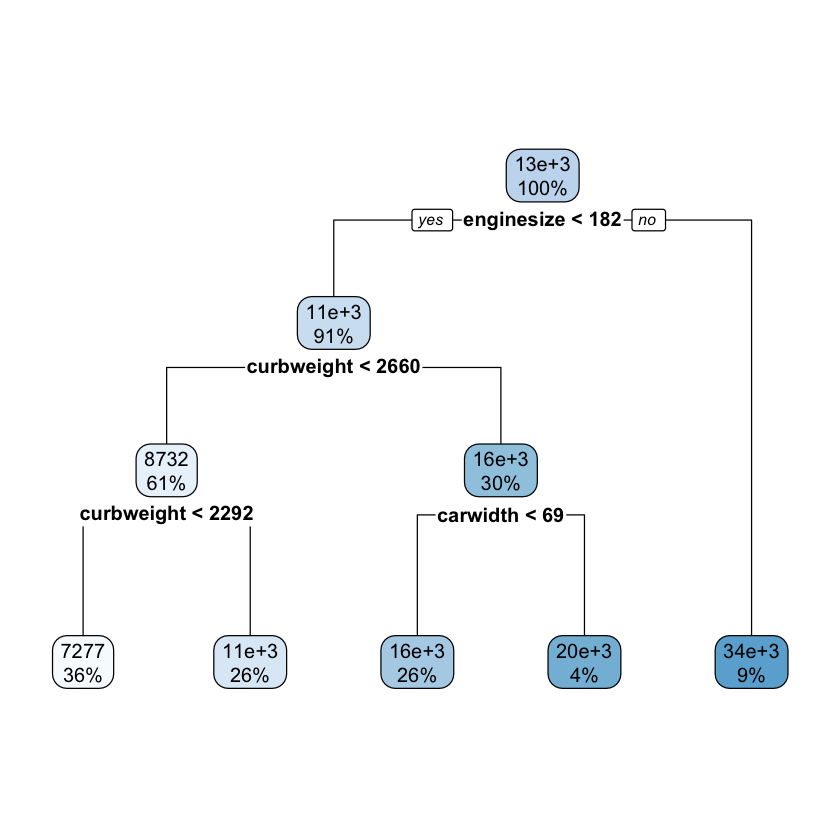

In [43]:
print("Árbol de decisión - Modelo Viejo")
rpart.plot(rpart(price~.,data=old_model_data))

[1] "Árbol de decisión - Modelo Nuevo"


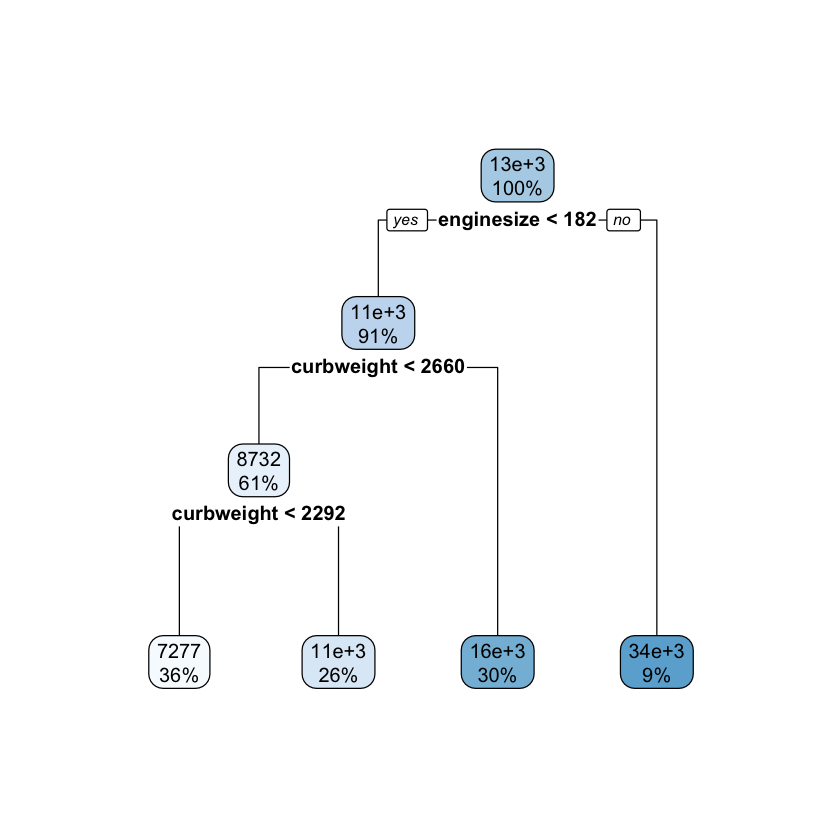

In [44]:
print("Árbol de decisión - Modelo Nuevo")
rpart.plot(rpart(price~.,data=new_model_data))